# Predictive Analytics

## Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px
import plotly.graph_objects as go

In [4]:
Rides = pd.read_csv("chicago_2018.csv", sep=",")

Rides["start_time"] = pd.to_datetime(Rides["start_time"])
Rides["end_time"] = pd.to_datetime(Rides["end_time"])

Rides.sort_values("start_time", inplace = True)
Rides.head(8)

start_time            end_time  start_station_id  \
3215937 2018-01-01 00:12:00 2018-01-01 00:17:23                69   
3215938 2018-01-01 00:41:35 2018-01-01 00:47:52               253   
3215939 2018-01-01 00:44:46 2018-01-01 01:33:10                98   
3215940 2018-01-01 00:53:10 2018-01-01 01:05:37               125   
3215941 2018-01-01 00:53:37 2018-01-01 00:56:40               129   
3215942 2018-01-01 00:56:15 2018-01-01 01:00:41               304   
3215943 2018-01-01 00:57:26 2018-01-01 01:02:40               164   
3215944 2018-01-01 01:00:29 2018-01-01 01:13:43               182   

         end_station_id           start_station_name  \
3215937             159       Damen Ave & Pierce Ave   
3215938             325  Winthrop Ave & Lawrence Ave   
3215939             509   LaSalle St & Washington St   
3215940             364         Rush St & Hubbard St   
3215941             205    Blue Island Ave & 18th St   
3215942             299      Broadway & Waveland Ave   
3215943             174        Franklin St & Lake St   
3215944             142            Wells St & Elm St   

                       end_station_name  bike_id   user_type  
3215937       Claremont Ave & Hirsch St     3304  Subscriber  
3215938  Clark St & Winnemac Ave (Temp)     5367  Subscriber  
3215939             Troy St & North Ave     4599  Subscriber  
3215940            Larrabee St & Oak St     2302  Subscriber  
3215941            Paulina St & 18th St     3696  Subscriber  
3215942          Halsted St & Roscoe St     6298  Subscriber  
3215943           Canal St & Madison St     1169  Subscriber  
3215944            McClurg Ct & Erie St     6351  Subscriber

The following cell is just for double checking the aggregated, hourly rental counts.

In [5]:
date1 = datetime.datetime(year=2018, month=1, day=1, hour = 5)
date2 = datetime.datetime(year=2018, month=1, day=1, hour = 6)

Rides[(Rides["start_time"] >= date1) & (Rides["start_time"] <= date2)]

start_time            end_time  start_station_id  \
3215973 2018-01-01 05:32:22 2018-01-01 05:40:04               206   
3215974 2018-01-01 05:46:51 2018-01-01 05:58:48                72   
3215975 2018-01-01 05:48:40 2018-01-01 05:53:01               303   

         end_station_id       start_station_name            end_station_name  \
3215973             339  Halsted St & Archer Ave       Emerald Ave & 31st St   
3215974              36     Wabash Ave & 16th St  Franklin St & Jackson Blvd   
3215975             296  Broadway & Cornelia Ave      Broadway & Belmont Ave   

         bike_id   user_type  
3215973      540  Subscriber  
3215974     3775  Subscriber  
3215975     4784  Subscriber

Computing the hourly demand for 2018. The result is stored in a DataFrame of 24 by 365 = 8760 rows, neglecting time change

In [6]:
date_index = date1 + pd.to_timedelta(np.arange(8760), 'H')

Features = pd.DataFrame(index = date_index)

Features["demand"] = 0

Features = Rides.set_index("start_time")
Features = Features.resample('H').count()

Features.drop(columns = "start_station_id", inplace = True)
Features.drop(columns = "end_station_id", inplace = True)
Features.drop(columns = "start_station_name", inplace = True)
Features.drop(columns = "end_station_name", inplace = True)
Features.drop(columns = "bike_id", inplace = True)
Features.drop(columns = "user_type", inplace = True)

Features.rename(columns = {"end_time": "Rides"}, inplace = True)

The resulting df can be double checked with one of the cells above or with the sorted Rides df. It seems reasonable though:

In [7]:
Features.describe()

Rides
count  8760.000000
mean    411.310731
std     479.667282
min       0.000000
25%      55.000000
50%     225.000000
75%     611.250000
max    2829.000000

In [8]:
Features.head()

Rides
start_time                
2018-01-01 00:00:00      7
2018-01-01 01:00:00     15
2018-01-01 02:00:00     10
2018-01-01 03:00:00      2
2018-01-01 04:00:00      2

In [9]:
x = Features.iloc[0]["Rides"]
x

7

In [10]:
Features["Rides_last_hour"] = 0
value = Features.iloc[0]["Rides"]
for i in Features.index:     
        Features.loc[i,"Rides_last_hour"] = value
        value = Features.loc[i]["Rides"]

There seems to be some erroneous data in the weather data set as there are rows which exhibit the same date, leading pandas to crash. (e.g. for index 1662, if duplicates were not removed.)

In [13]:
Weather = pd.read_csv("weather_hourly_chicago.csv", sep=",")

Weather["avg_tmp"] = (Weather["max_temp"]+Weather["min_temp"])/2
Weather["is_raining"] = Weather["precip"] == 1
Weather.drop(columns = ["max_temp", "min_temp", "precip"], inplace=True)

Weather["date_time"] = pd.to_datetime(Weather["date_time"])

Weather.set_index("date_time", inplace = True)
Features = Features.join(Weather, on="start_time")

Lots of missing values for weather, imputation methods:

* numerical values: linear interpolation (time series data)
* categorical (is_raining): backwards-fill

In [14]:
Features.interpolate(inplace=True)
Features.fillna(method="bfill",inplace=True)

In [15]:
Features[Features["is_raining"].isnull()]

Empty DataFrame
Columns: [Rides, Rides_last_hour, avg_tmp, is_raining]
Index: []

In [16]:
len(Features[Features["is_raining"] == True])

1023

In [17]:
Features.describe()

Rides  Rides_last_hour      avg_tmp
count  9361.000000      9361.000000  9361.000000
mean    405.986754       405.733255    10.460314
std     474.935071       475.283195    11.814070
min       0.000000         0.000000   -22.800000
25%      54.000000        54.000000     1.100000
50%     222.000000       221.000000     9.400000
75%     605.000000       603.000000    21.100000
max    2829.000000      2829.000000    36.100000

In [18]:
Features.reset_index(inplace=True)

In [19]:
Features["is_workday"] = Features["start_time"].apply(lambda x: x.weekday() < 5)
Features["hour"] = Features["start_time"].apply(lambda x: x.hour)
Features["month"] = Features["start_time"].apply(lambda x: x.month)

In [20]:
def getSeason(month):
    
    Winter = [12, 1, 2]
    Spring = [3, 4, 5]
    Summer = [6, 7, 8]
    Fall = [9, 10, 11]
    
    if month in Winter:
        return 1
    elif month in Spring:
        return 2
    elif month in Summer:
        return 3
    elif month in Fall:
        return 4
    
Features["season"] = Features["month"].apply(lambda month: getSeason(month))

In [21]:
seasons = pd.get_dummies(Features["season"],prefix="season_")
seasons.drop(columns="season__4", inplace=True)

In [22]:
Features[list(seasons.columns)] = seasons

In [23]:
hours = pd.get_dummies(Features["hour"],prefix="hour_")
hours.drop(columns="hour__23", inplace=True)

In [24]:
Features[list(hours.columns)] = hours

In [25]:
Features.drop(columns=["season","month","hour"], inplace=True)

In [26]:
Features

start_time  Rides  Rides_last_hour  avg_tmp  is_raining  \
0    2018-01-01 00:00:00      7                7   -13.90       False   
1    2018-01-01 01:00:00     15                7   -15.00       False   
2    2018-01-01 02:00:00     10               15   -15.60       False   
3    2018-01-01 03:00:00      2               10   -16.70       False   
4    2018-01-01 04:00:00      2                2   -17.20       False   
...                  ...    ...              ...      ...         ...   
9356 2018-12-31 19:00:00     41               45     3.30        True   
9357 2018-12-31 20:00:00     28               41     3.60        True   
9358 2018-12-31 21:00:00     22               28     3.45       False   
9359 2018-12-31 22:00:00     25               22     3.30       False   
9360 2018-12-31 23:00:00     35               25     3.30        True   

      is_workday  season__1  season__2  season__3  hour__0  ...  hour__13  \
0           True          1          0          0        1  ...         0   
1           True          1          0          0        0  ...         0   
2           True          1          0          0        0  ...         0   
3           True          1          0          0        0  ...         0   
4           True          1          0          0        0  ...         0   
...          ...        ...        ...        ...      ...  ...       ...   
9356        True          1          0          0        0  ...         0   
9357        True          1          0          0        0  ...         0   
9358        True          1          0          0        0  ...         0   
9359        True          1          0          0        0  ...         0   
9360        True          1          0          0        0  ...         0   

      hour__14  hour__15  hour__16  hour__17  hour__18  hour__19  hour__20  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         0         0         0         0         0   
3            0         0         0         0         0         0         0   
4            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9356         0         0         0         0         0         1         0   
9357         0         0         0         0         0         0         1   
9358         0         0         0         0         0         0         0   
9359         0         0         0         0         0         0         0   
9360         0         0         0         0         0         0         0   

      hour__21  hour__22  
0            0         0  
1            0         0  
2            0         0  
3            0         0  
4            0         0  
...        ...       ...  
9356         0         0  
9357         0         0  
9358         1         0  
9359         0         1  
9360         0         0  

[9361 rows x 32 columns]

Re-Scaling the data

In [33]:
Features_rescaled = pd.DataFrame()

Features_rescaled["Rides"] = (Features["Rides"] - Features["Rides"].min()) / (Features["Rides"].max() - Features["Rides"].min())
Features_rescaled["Rides_last_hour"] = (Features["Rides_last_hour"] - Features["Rides_last_hour"].min()) / (Features["Rides_last_hour"].max() - Features["Rides_last_hour"].min())
#Features_rescaled["Max_temp"] = (Features["Max_temp"] - Features["Max_temp"].min()) / (Features["Max_temp"].max() - Features["Max_temp"].min())
#Features_rescaled["Min_temp"] = (Features["Min_temp"] - Features["Min_temp"].min()) / (Features["Min_temp"].max() - Features["Min_temp"].min())
Features_rescaled["avg_tmp"] = (Features["avg_tmp"] - Features["avg_tmp"].min()) / (Features["avg_tmp"].max() - Features["avg_tmp"].min())
#Features_rescaled["is_raining"] = (Features["is_raining"] - Features["is_raining"].min()) / (Features["is_raining"].max() - Features["is_raining"].min())
#Features_rescaled["is_workday"] = (Features["Day_of_Week"] - Features["Day_of_Week"].min()) / (Features["Day_of_Week"].max() - Features["Day_of_Week"].min())
#Features_rescaled["Hour"] = (Features["Hour"] - Features["Hour"].min()) / (Features["Hour"].max() - Features["Hour"].min())
#Features_rescaled["Month"] = (Features["Month"] - Features["Month"].min()) / (Features["Month"].max() - Features["Month"].min())
#Features_rescaled["Season"] = (Features["Season"] - Features["Season"].min()) / (Features["Season"].max() - Features["Season"].min())

Features_rescaled.head()

Rides  Rides_last_hour   avg_tmp
0  0.002474         0.002474  0.151104
1  0.005302         0.002474  0.132428
2  0.003535         0.005302  0.122241
3  0.000707         0.003535  0.103565
4  0.000707         0.000707  0.095076

In [35]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=Features["start_time"], y=Features_rescaled["Rides"],
                    mode='lines',
                    name='Demand'))
fig.add_trace(go.Scatter(x=Features["start_time"], y=Features_rescaled["avg_tmp"],
                    mode='lines+markers',
                    name='Max. Temperature'))

fig.show()

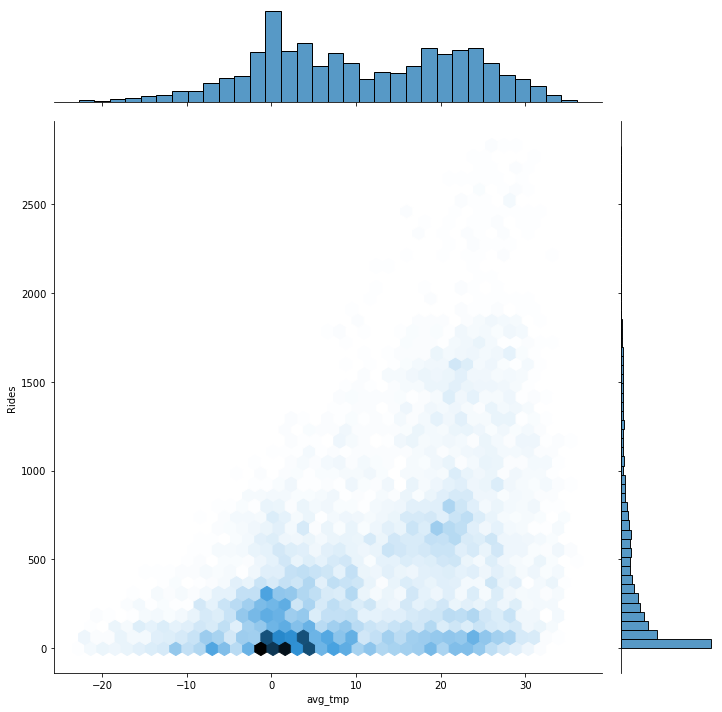

In [36]:
sns.jointplot(x = "avg_tmp", y = "Rides", data = Features, kind = "hex", height=10, palette = "magma")

In [37]:
sns.pairplot(Features, palette="magma", height=3, hue="is_raining")
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000234884A2B80> (for post_execute):


KeyboardInterrupt: 

In [38]:
Features.cov()

Rides  Rides_last_hour      avg_tmp  is_raining  \
Rides            225563.321406    192883.046680  2497.967648  -19.802826   
Rides_last_hour  192883.046680    225894.115485  2652.123916  -21.530355   
avg_tmp            2497.967648      2652.123916   139.572241   -0.591888   
is_raining          -19.802826       -21.530355    -0.591888    0.097351   
is_workday           20.452841        20.297542     0.124580    0.000867   
season__1           -62.293569       -62.387480    -2.993356    0.019299   
season__2           -14.603757       -14.756946    -0.417907   -0.001860   
season__3            70.548283        70.877228     3.251401   -0.014762   
hour__0             -14.475834       -12.683914     0.052231    0.000551   
hour__1             -15.389192       -14.355339     0.026995   -0.000600   
hour__2             -15.537818       -14.970503    -0.003754    0.000383   
hour__3             -16.618562       -16.285908    -0.032072    0.000279   
hour__4             -15.863774       -16.013337    -0.032412   -0.000091   
hour__5             -13.328827       -16.196870    -0.055442    0.000670   
hour__6              -4.836740       -13.118594    -0.056331    0.001369   
hour__7               9.422884        -4.859876    -0.076299    0.000231   
hour__8              16.168080         9.505915    -0.088528   -0.000445   
hour__9               1.005998        16.219391    -0.089729   -0.000363   
hour__10             -1.631172         0.996620    -0.101319   -0.000018   
hour__11              2.383471        -1.733180    -0.115598    0.000256   
hour__12              5.450870         2.377190    -0.097772    0.000384   
hour__13              5.232079         5.487275    -0.074471    0.001027   
hour__14              4.510164         4.972916    -0.034527    0.000278   
hour__15              9.138478         4.530637     0.005709    0.000373   
hour__16             22.312627         9.166513     0.036032    0.000124   
hour__17             32.827474        22.200723     0.075971    0.000052   
hour__18             15.916579        33.182083     0.101484    0.000349   
hour__19              4.979499        15.730231     0.118263   -0.001195   
hour__20             -2.383964         5.152745     0.122613   -0.000542   
hour__21             -6.753833        -2.711728     0.116614   -0.001634   
hour__22             -9.659499        -6.569398     0.113733   -0.001171   

                 is_workday  season__1  season__2  season__3    hour__0  \
Rides             20.452841 -62.293569 -14.603757  70.548283 -14.475834   
Rides_last_hour   20.297542 -62.387480 -14.756946  70.877228 -12.683914   
avg_tmp            0.124580  -2.993356  -0.417907   3.251401   0.052231   
is_raining         0.000867   0.019299  -0.001860  -0.014762   0.000551   
is_workday         0.204031  -0.001981   0.001042   0.000294  -0.000114   
season__1         -0.001981   0.188305  -0.062571  -0.062760  -0.000066   
season__2          0.001042  -0.062571   0.186864  -0.062040   0.000268   
season__3          0.000294  -0.062760  -0.062040   0.187239  -0.000297   
hour__0           -0.000114  -0.000066   0.000268  -0.000297   0.040127   
hour__1           -0.000175  -0.000226   0.000108   0.000077  -0.001745   
hour__2            0.000024  -0.000037   0.000187  -0.000057  -0.001696   
hour__3            0.000252   0.000334  -0.000185  -0.000323  -0.001776   
hour__4            0.000253  -0.000358   0.000080   0.000370  -0.001714   
hour__5           -0.000465   0.000175  -0.000132  -0.000164  -0.001749   
hour__6           -0.000297  -0.000225   0.000214   0.000183  -0.001727   
hour__7           -0.000221  -0.000387   0.000055   0.000344  -0.001754   
hour__8            0.000084   0.000281   0.000189  -0.000377  -0.001767   
hour__9            0.000085  -0.000600   0.000375  -0.000084  -0.001736   
hour__10          -0.000022  -0.000040  -0.000132   0.000264  -0.001767   
hour__11          -0.000007   0.000280  -0.000024  -0.000163  -0.001785   
hour__12         

In [39]:
Features_corr = Features.corr()
Features_corr

Rides  Rides_last_hour   avg_tmp  is_raining  is_workday  \
Rides            1.000000         0.854491  0.445198   -0.133636    0.095339   
Rides_last_hour  0.854491         1.000000  0.472326   -0.145187    0.094546   
avg_tmp          0.445198         0.472326  1.000000   -0.160572    0.023345   
is_raining      -0.133636        -0.145187 -0.160572    1.000000    0.006151   
is_workday       0.095339         0.094546  0.023345    0.006151    1.000000   
season__1       -0.302258        -0.302492 -0.583885    0.142539   -0.010104   
season__2       -0.071132        -0.071826 -0.081831   -0.013792    0.005336   
season__3        0.343284         0.344632  0.636023   -0.109343    0.001504   
hour__0         -0.152157        -0.133225  0.022071    0.008822   -0.001258   
hour__1         -0.162154        -0.151150  0.011435   -0.009631   -0.001938   
hour__2         -0.165977        -0.159800 -0.001612    0.006222    0.000267   
hour__3         -0.173625        -0.170025 -0.013470    0.004442    0.002772   
hour__4         -0.168610        -0.170075 -0.013849   -0.001479    0.002823   
hour__5         -0.140272        -0.170331 -0.023456    0.010731   -0.005144   
hour__6         -0.051216        -0.138811 -0.023979    0.022071   -0.003306   
hour__7          0.099045        -0.051045 -0.032241    0.003694   -0.002439   
hour__8          0.169327         0.099482 -0.037272   -0.007097    0.000930   
hour__9          0.010626         0.171197 -0.038102   -0.005844    0.000940   
hour__10        -0.017083         0.010430 -0.042657   -0.000284   -0.000246   
hour__11         0.024842        -0.018051 -0.048435    0.004061   -0.000078   
hour__12         0.057577         0.025091 -0.041517    0.006181   -0.000247   
hour__13         0.054663         0.057287 -0.031278    0.016336   -0.000749   
hour__14         0.047640         0.052490 -0.014662    0.004463   -0.000247   
hour__15         0.096409         0.047762  0.002421    0.005986    0.004832   
hour__16         0.234531         0.096280  0.015225    0.001985   -0.001258   
hour__17         0.346324         0.234042  0.032220    0.000839   -0.002278   
hour__18         0.167506         0.348952  0.042935    0.005597    0.003131   
hour__19         0.052728         0.166445  0.050343   -0.019258   -0.000927   
hour__20        -0.025275         0.054590  0.052259   -0.008749    0.001114   
hour__21        -0.071428        -0.028658  0.049580   -0.026302   -0.001774   
hour__22        -0.102539        -0.069685  0.048535   -0.018929    0.000775   

                 season__1  season__2  season__3   hour__0   hour__1  ...  \
Rides            -0.302258  -0.071132   0.343284 -0.152157 -0.162154  ...   
Rides_last_hour  -0.302492  -0.071826   0.344632 -0.133225 -0.151150  ...   
avg_tmp          -0.583885  -0.081831   0.636023  0.022071  0.011435  ...   
is_raining        0.142539  -0.013792  -0.109343  0.008822 -0.009631  ...   
is_workday       -0.010104   0.005336   0.001504 -0.001258 -0.001938  ...   
season__1         1.000000  -0.333566  -0.334233 -0.000759 -0.002605  ...   
season__2        -0.333566   1.000000  -0.331673  0.003101  0.001250  ...   
season__3        -0.334233  -0.331673   1.000000 -0.003427  0.000888  ...   
hour__0          -0.000759   0.003101  -0.003427  1.000000 -0.043590  ...   
hour__1          -0.002605   0.001250   0.000888 -0.043590  1.000000  ...   
hour__2          -0.000434   0.002189  -0.000673 -0.042944 -0.042830  ...   
hour__3           0.003817  -0.002122  -0.003709 -0.043996 -0.043879  ...   
hour__4          -0.004168   0.000937   0.004318 -0.043180 -0.043065  ...   
hour__5           0.002011  -0.001530  -0.001889 -0.043648 -0.043532  ...   
hour__6          -0.002610   0.002492   0.002131 -0.043356 -0.043240  ...   
hour__7          -0.004446   0.000633   0.003969 -0.043706 -0.043590  ...   
hour__8           0.003218   0.002172  -0.004333 -0.043880 -0.043763  ...   
hour__9          -0.006931   0.004349  -0.000969 -0.043473 -0.043357  ...

<AxesSubplot:>

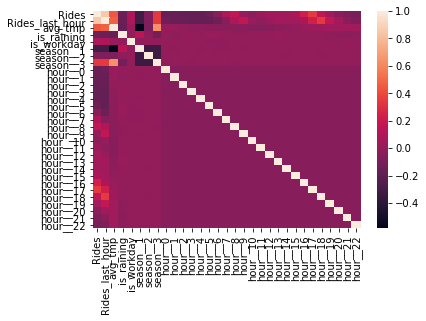

In [40]:
sns.heatmap(Features_corr, 
        xticklabels=Features_corr.columns,
        yticklabels=Features_corr.columns)

[Source](https://stackoverflow.com/questions/39409866/correlation-heatmap) for the following code:

In [41]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

Features_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [42]:
Features_rescaled.var()

Rides              0.028184
Rides_last_hour    0.028225
avg_tmp            0.040232
dtype: float64

<ipython-input-43-e16c00059b17>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<AxesSubplot:xlabel='avg_tmp', ylabel='Rides'>

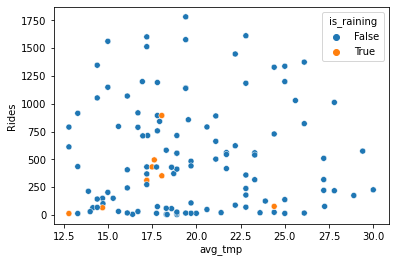

In [43]:
Features_sample = Features[3100:3220]
Features_sample = Features_sample[Features["avg_tmp"] != 0]
#Features_sample = Features.sample(n=125)
#Features_sample = Features_sample[Features["Max_temp"] != 0]

sns.scatterplot(x = Features_sample["avg_tmp"], y = Features_sample["Rides"], hue = Features_sample["is_raining"])

In [44]:
fig = px.density_heatmap(Features, x='avg_tmp', y='Rides', width=600, height=600,
                      title='Correlation between Temperature and Demand', color_continuous_scale=[[0.0, 'white'], [1.0, 'red']],
                        nbinsx=25, nbinsy=25)
fig.show()

In [45]:
fig = px.parallel_coordinates(data_frame = Features, dimensions =[""])

fig.show()

ValueError: Value of 'dimensions_0' is not the name of a column in 'data_frame'. Expected one of ['start_time', 'Rides', 'Rides_last_hour', 'avg_tmp', 'is_raining', 'is_workday', 'season__1', 'season__2', 'season__3', 'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6', 'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22'] but received: 

In [ ]:
fig = px.scatter_3d(data_frame = Features_sample, z='Max_temp', x='Rides', y='Hour', color='Precipitation', opacity=0.4, size_max=5)

fig.show()

In [ ]:
fig = px.scatter_3d(data_frame = Features_sample, z='Max_temp', x='Rides', y='Rides_last_hour', color='Precipitation', opacity=0.4, size_max=5)

fig.show()

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split the data with 70-30% split as above

X = Features[Features.columns[(Features.columns != "Rides") & (Features.columns != "start_time")]]
y = Features["Rides"]
X,y
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
X

In [ ]:
x_train, x_test, y_train, y_test

fangt hier an...

In [88]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
Features

start_time  Rides  Rides_last_hour  avg_tmp  is_raining  \
0    2018-01-01 00:00:00      7                7   -13.90       False   
1    2018-01-01 01:00:00     15                7   -15.00       False   
2    2018-01-01 02:00:00     10               15   -15.60       False   
3    2018-01-01 03:00:00      2               10   -16.70       False   
4    2018-01-01 04:00:00      2                2   -17.20       False   
...                  ...    ...              ...      ...         ...   
9356 2018-12-31 19:00:00     41               45     3.30        True   
9357 2018-12-31 20:00:00     28               41     3.60        True   
9358 2018-12-31 21:00:00     22               28     3.45       False   
9359 2018-12-31 22:00:00     25               22     3.30       False   
9360 2018-12-31 23:00:00     35               25     3.30        True   

      is_workday  season__1  season__2  season__3  hour__0  ...  hour__13  \
0           True          1          0          0        1  ...         0   
1           True          1          0          0        0  ...         0   
2           True          1          0          0        0  ...         0   
3           True          1          0          0        0  ...         0   
4           True          1          0          0        0  ...         0   
...          ...        ...        ...        ...      ...  ...       ...   
9356        True          1          0          0        0  ...         0   
9357        True          1          0          0        0  ...         0   
9358        True          1          0          0        0  ...         0   
9359        True          1          0          0        0  ...         0   
9360        True          1          0          0        0  ...         0   

      hour__14  hour__15  hour__16  hour__17  hour__18  hour__19  hour__20  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         0         0         0         0         0   
3            0         0         0         0         0         0         0   
4            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9356         0         0         0         0         0         1         0   
9357         0         0         0         0         0         0         1   
9358         0         0         0         0         0         0         0   
9359         0         0         0         0         0         0         0   
9360         0         0         0         0         0         0         0   

      hour__21  hour__22  
0            0         0  
1            0         0  
2            0         0  
3            0         0  
4            0         0  
...        ...       ...  
9356         0         0  
9357         0         0  
9358         1         0  
9359         0         1  
9360         0         0  

[9361 rows x 32 columns]

In [69]:
xp=Features['avg_tmp'].values
yp=Features['Rides'].values

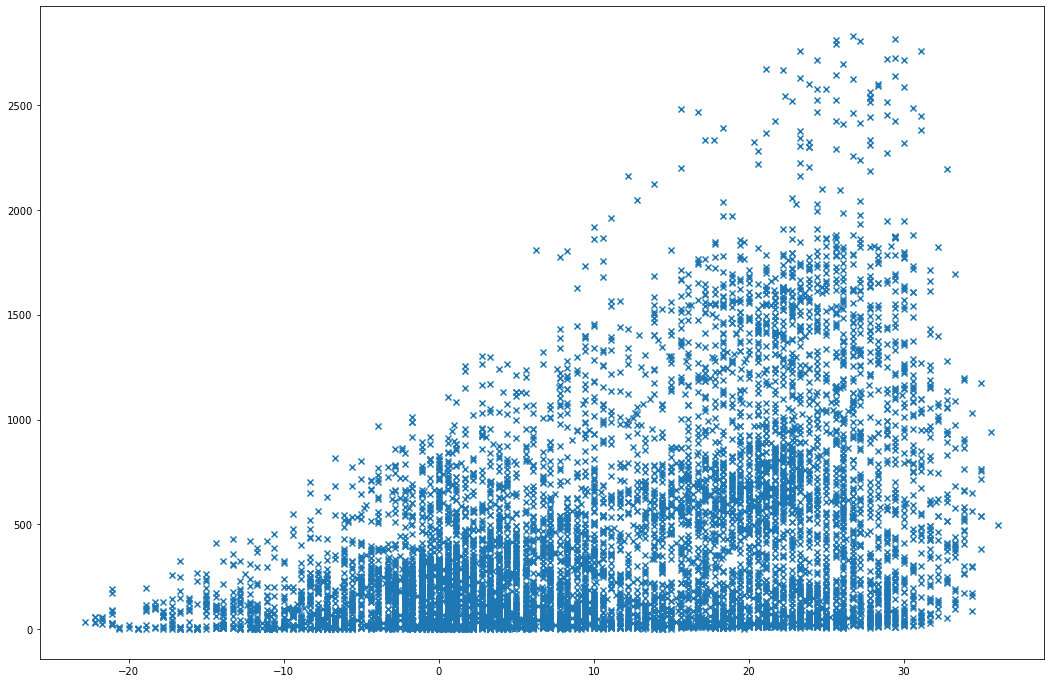

In [50]:
fig, ax = plt.subplots(figsize=(18,12))

plt.scatter(Features['avg_tmp'], Features['Rides'], marker='x')

plt.show()

# Polynomial Regression

In [51]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    # create scaled test dataset
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # Plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # prints first 3 thetas

[ 3.41720486e+09 -6.87881885e+09  9.24744415e+09  1.45669120e+10
 -1.05348037e+10 -2.02099887e+10 -1.40528994e+10]


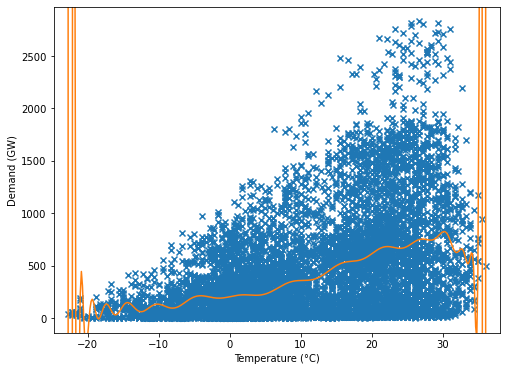

In [94]:
plot_regression_poly(Features['avg_tmp'].values, Features['Rides'].values, d=100)

As we can see here, we have some overfitting, which means that we have less error in this sample, but we will have more error in another sample, because the line targets the exact points when reaching a certain temperature.

# Regularization

In [95]:
def ls_poly_reg(x, y, lam, degree):
    xs = 2*(x - min(x))/(max(x) - min(x)) - 1   # rescale to range [-1,1]
    X = np.array([xs**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

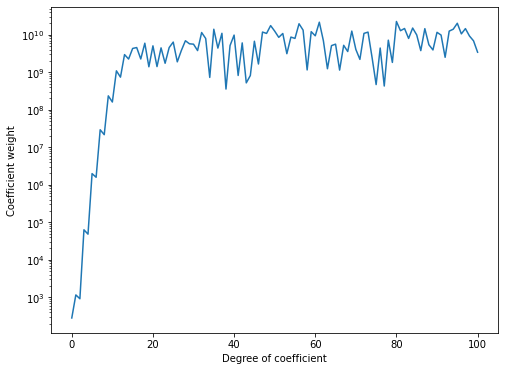

In [101]:
# Define inputs
x=Features['avg_tmp'].values
y=Features['Rides'].values
lam=0
degree= 100

# Plot function
theta = ls_poly_reg(x, y, lam, degree)

plt.figure(figsize = (8,6))
plt.semilogy(range(degree+1), np.abs(theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")
plt.show()

# L2 / Ridge Regression

In [82]:
# initialize model
Poly = PolynomialFeatures(degree = 50)

# fit and transform xp
X_poly = Poly.fit_transform(xp.reshape(-1,1))

In [83]:
model_L2 = Ridge(alpha = 0.01, normalize = True, solver = 'lsqr') # select least squares regression as solver

model_L2.fit(X_poly, yp)
prediction = model_L2.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 0.00000000e+00  1.12642343e+01  2.50160576e-01  6.19662774e-03
  8.11188473e-05  1.01651221e-06 -2.55681498e-08 -1.49377052e-09
 -6.57727936e-11 -2.13755652e-12 -6.66974790e-14 -1.87813478e-15
 -5.14413330e-17 -1.32612735e-18 -3.31093777e-20 -7.81024851e-22
 -1.74583676e-23 -3.54997694e-25 -6.16623989e-27 -6.69611751e-29
  9.68961246e-31  1.02693993e-31  4.82521521e-33  1.84504262e-34
  6.38109370e-36  2.07707994e-37  6.48075986e-39  1.95847383e-40
  5.76624612e-42  1.66020499e-43  4.68413517e-45  1.29643169e-46
  3.52006875e-48  9.36838103e-50  2.43907525e-51  6.19008504e-53
  1.52219399e-54  3.58946050e-56  7.96040663e-58  1.59220257e-59
  2.54889342e-61  1.48551689e-63 -1.23868354e-64 -8.26770294e-66
 -3.69579903e-67 -1.42928001e-68 -5.12166751e-70 -1.75008898e-71
 -5.78761530e-73 -1.86853251e-74 -5.92202912e-76] 
Intercept  206.9843741626473


In [84]:


# function for plotting

def plot_scikit_output (x, y, fitted_model):
    
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly), 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)



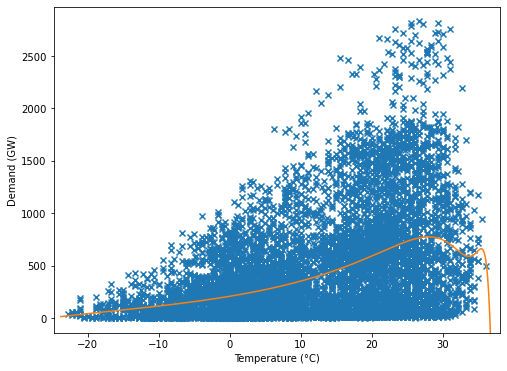

In [85]:
plot_scikit_output (xp, yp, model_L2)

# L1 / Lasso Regression

In [89]:
model_L1 = Lasso(alpha = 1)

model_L1.fit(X_poly, yp)
predict = model_L1.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 0.00000000e+00  1.12642343e+01  2.50160576e-01  6.19662774e-03
  8.11188473e-05  1.01651221e-06 -2.55681498e-08 -1.49377052e-09
 -6.57727936e-11 -2.13755652e-12 -6.66974790e-14 -1.87813478e-15
 -5.14413330e-17 -1.32612735e-18 -3.31093777e-20 -7.81024851e-22
 -1.74583676e-23 -3.54997694e-25 -6.16623989e-27 -6.69611751e-29
  9.68961246e-31  1.02693993e-31  4.82521521e-33  1.84504262e-34
  6.38109370e-36  2.07707994e-37  6.48075986e-39  1.95847383e-40
  5.76624612e-42  1.66020499e-43  4.68413517e-45  1.29643169e-46
  3.52006875e-48  9.36838103e-50  2.43907525e-51  6.19008504e-53
  1.52219399e-54  3.58946050e-56  7.96040663e-58  1.59220257e-59
  2.54889342e-61  1.48551689e-63 -1.23868354e-64 -8.26770294e-66
 -3.69579903e-67 -1.42928001e-68 -5.12166751e-70 -1.75008898e-71
 -5.78761530e-73 -1.86853251e-74 -5.92202912e-76] 
Intercept  206.9843741626473


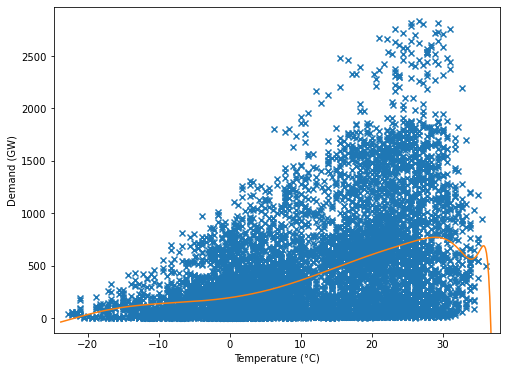

In [87]:
plot_scikit_output (xp, yp, model_L1)

In [72]:
def plot_L2_regression_performance (x, y, deg):

    err_train = []
    err_cv = []
    
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

    for alpha in np.logspace(-15,10,100):

        # create poly features
        poly_reg = PolynomialFeatures (degree = deg)
        X_train_poly = poly_reg.fit_transform(x_train.reshape(-1,1))
        X_test_poly = poly_reg.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = alpha, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

In [79]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

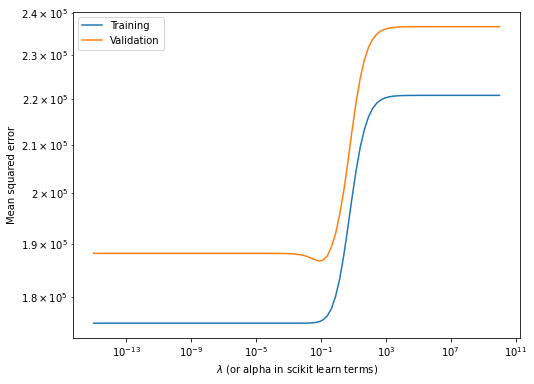

In [80]:
plot_L2_regression_performance(xp,yp,75)